# Face Detection by using Viola-Jones algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import time
import progressbar
from PIL import Image
from multiprocessing import cpu_count, Pool
from functools import partial

## Data Load

In [2]:
dir1 = "/Users/apple/Dev/Dataset/faces/"
dir2 = "/Users/apple/Dev/Dataset/background/"

faces = os.listdir(dir1)
backgrounds = os.listdir(dir2)

# Delete non image file

for i in range(len(faces)):
    if faces[i]=='.DS_Store':
        temp=i
faces.pop(temp)

for i in range(len(backgrounds)):
    if backgrounds[i]=='.DS_Store':
        temp=i
backgrounds.pop(temp)

faces_training = []
faces_testing = []
for i in range(len(faces)):
    if i < 1900 :
        img = Image.open(dir1 + faces[i]).convert('L')
        img_np = np.asarray(img) 
        img_np = img_np/255  # Normalize
        faces_training.append(img_np)
    elif i < 2000:
        img = Image.open(dir1 + faces[i]).convert('L')
        img_np = np.asarray(img) 
        img_np = img_np/255  # Normalize
        faces_testing.append(img_np)
        

non_faces_training = []
non_faces_testing = []
for i in range(len(backgrounds)):
    if i < 1900:
        img = Image.open(dir2 + backgrounds[i]).convert('L')
        img_np = np.asarray(img)
        img_np = img_np/255
        non_faces_training.append(img_np)
    elif i < 2000:
        img = Image.open(dir2 + backgrounds[i]).convert('L')
        img_np = np.asarray(img)
        img_np = img_np/255
        non_faces_testing.append(img_np)

##  Convert Image data to cummulative pixel data

In [3]:
def integral_image(picture):
    return picture.cumsum(1).cumsum(0) # add all of col per row, and add all of rows per col

In [4]:
print('Loading faces for training..')

faces_ii_training = list(map(integral_image, faces_training))
print('..done. ' + str(len(faces_training)) + ' faces loaded.\n\nLoading non faces..')
non_faces_ii_training = list(map(integral_image, non_faces_training))
print('..done. ' + str(len(non_faces_training)) + ' non faces loaded.\n')

print('Loading faces for testing..')
faces_ii_testing = list(map(integral_image, faces_testing))
print('..done. ' + str(len(faces_testing)) + ' faces loaded.\n\nLoading non faces..')
non_faces_ii_testing = list(map(integral_image, non_faces_testing))
print('..done. ' + str(len(non_faces_testing)) + ' non faces loaded.\n')

Loading faces for training..
..done. 1900 faces loaded.

Loading non faces..
..done. 1900 non faces loaded.

Loading faces for testing..
..done. 100 faces loaded.

Loading non faces..
..done. 100 non faces loaded.



In [5]:
images = faces_ii_training + non_faces_ii_training
num_pos = len(faces_ii_training)
num_neg = len(non_faces_ii_training)
num_imgs = num_pos + num_neg
img_height, img_width = faces_ii_training[0].shape

## Generate Feature 

In [6]:
# Feature Table for square feature
features = []

# For performance reasons restricting feature size
max_feature_height = 10
max_feature_width = 10

stride = 2
increment = 2

# Type2
cnt2 = 0
i = 0
while i < img_height:
    j = 0
    while j < img_width:
        h = 4
        while (i+h < img_height):
            w = 4
            while (j+w < img_width):
                features.append([(i,j),(i+h//2,j+w),(i+h//2,j),(i+h,j+w)]) # Type2 a
                features.append([(i,j),(i+h,j+w//2),(i,j+w//2),(i+h,j+w)]) # Type2 b
                cnt2+=2
                w += increment
                if(w > max_feature_width):
                    break
            h += increment
            if(h > max_feature_height):
                break
        j += stride
    i += stride

# Type3
cnt3 = 0
i = 0
while i < 64:
    j = 0
    while j < 64:
        h = 4
        while (i+h+h//2 < 64):
            w = 4
            while (j+w+w//2 < 64):
                # [Type3, Type4]
                features.append([(i,j),(i+h//2,j+w),(i+h//2,j),(i+h,j+w),(i+h,j),(i+h+h//2,j+w)])  # Type3 a
                features.append([(i,j),(i+h,j+w//2),(i,j+w//2),(i+h,j+w),(i,j+w),(i+h, j+w+w//2)]) # Type3 b
                cnt3+=2
                w += increment
                if(w > max_feature_width):
                    break
            h += increment
            if(h > max_feature_height):
                break
        j += stride
    i += stride

In [7]:
print("The number of type2 features :", cnt2)
print("The number of type3 features :", cnt3)
print("The number of total featurez :", len(features))

The number of type2 features : 25992
The number of type3 features : 23328
The number of total featurez : 49320


## Compute Feature Value 

In [8]:
def integrate(feature, ii):

    r0, c0 = feature[0]
    r1, c1 = feature[1]  
    r2, c2 = feature[2]
    r3, c3 = feature[3]
    
    r,c = np.shape(ii)
    temp = np.zeros([r+1,c+1], float) # Padding zeros
    
    temp[1:,1:] = ii
    S1 = 0
    D = temp[r1, c1]
    A = temp[r0-1, c0-1]
    B = temp[r0-1, c1]
    C = temp[r1, c0-1]
    S1 = D - (B+C) + A
    
    temp[1:, 1:] = ii
    S2 = 0
    D = temp[r3, c3]
    A = temp[r2-1, c2-1]
    B = temp[r2-1, c3]
    C = temp[r3, c2-1]
    S2 = D - (B+C) + A
    
    if len(feature) == 4:
        return S1-S2
    elif len(feature) == 6:
        r4, c4 = feature[4]
        r5, c5 = feature[5]
        temp[1:, 1:] = ii
        S3 = 0
        D = temp[r5, c5]
        A = temp[r4-1, c4-1]
        B = temp[r4-1, c5]
        C = temp[r5, c4-1]
        S3 = D - (B+C) + A
        
        return S1-S2+S3

In [9]:
print('Calculating scores for images..')

start = time.clock()

num_features = len(features)
scores = np.zeros((num_imgs, num_features))
bar = progressbar.ProgressBar()
pool = Pool(processes=(cpu_count()))

for i in bar(range(num_imgs)):
    scores[i, :] = np.array(list(pool.map(partial(integrate, ii=images[i]), features)))

bar.finish()
pool.terminate()

end = time.clock() - start

Calculating scores for images..


100% |########################################################################|


In [10]:
print("It takes " + time.strftime('%H:%M:%S', time.gmtime(end)))

It takes 00:05:13


## Select Features 

In [11]:
# Computes the minimum error for several features

def Error(scores, w, label):
    
    # We need to find polarity and theta, parameters of h(x,the, polar) to compure the predict.

    feat = np.column_stack((scores,w,label))
    feat = sorted(feat, key = lambda x: x[0]) # Sort feature scores by ascending
    feat = np.asarray(feat)

    label_p = feat[:,2]*(feat[:,2] > 0)       # Positive label
    label_m = -1*feat[:,2]*(feat[:,2] < 0)    # Negative label
    weight = feat[:,1]                        # Weight (D)
    
    splus = (np.multiply(label_p, weight)).cumsum(0)
    sminus = (np.multiply(label_m, weight)).cumsum(0)
    tplus = splus[-1]
    tminus = sminus[-1]
                       
    epsilon = []  # List of error of one feature for all images
    polar   = []  # List of polarity
    
    for i in range(len(scores)):
        temp1 = splus[i]+tminus-sminus[i]
        temp2 = sminus[i]+tplus-sminus[i]
        if temp1 < temp2:
            epsilon.append(temp1)
            polar.append(1)
        else:
            epsilon.append(temp2)
            polar.append(-1)
    return epsilon, polar 

In [12]:
def bestlearner():
    error = np.ones(num_features)*np.inf        # List of total errors in each features
    theta = np.zeros(num_features)
    polar = np.zeros(num_features)
    err = np.zeros((num_features, num_imgs))
    h = np.zeros((num_features, num_imgs))
    fpr = 0
    dr = 0
    
    # select best classifier based on the weighted error
    for f_idx in feature_indexes:
        # Find threshold and polarity for ith feature.
        e, p = Error(scores[:,f_idx], weights, labels)
        min_error_idx = np.argmin(e)          # Index for minimum error of image in the feature     
        th = scores[min_error_idx, f_idx]     #  New threshold for this feature
        po = p[min_error_idx]                 # New polarity for this feature
        
        # Find expected label and error for all images in ith feature.
        for i in range(num_imgs):   
            if po*scores[i, f_idx] > po*th:
                h[f_idx,i] = 1
                err[f_idx, i] = 0 if labels[i] == 1 else 1
            else:
                h[f_idx,i] = -1
                err[f_idx, i] = 0 if labels[i] == -1 else 1
        
        # Threshold, Polarity and Weighted error rate of ith feature.
        theta[f_idx] = th
        polar[f_idx] = po
        error[f_idx] = np.sum(np.multiply(weights, err[f_idx, :]))

    # Find the best classifier with minimum error
    error_t_index = np.argmin(error)              # Weak classifier index
    error_t = error[error_t_index]                # Error of Weak classifier
    misclassified_t = err[error_t_index, :]
    classif_result = h[error_t_index, :]
    
    dr = sum(h[error_t_index, :][:num_pos] == 1)/num_pos
    fpr = sum(h[error_t_index, :][num_neg:] == 1)/num_neg
    
    # Update current weight
    beta_t  = error_t / (1-error_t)
    for i in range(num_imgs):
        weights[i] *= beta_t ** (1-misclassified_t[i])
        
    np.delete(feature_indexes, np.argwhere(feature_indexes==error_t_index))
    
    return error_t_index, theta[error_t_index], polar[error_t_index], np.log(1 / beta_t), classif_result, dr, fpr

In [13]:
# select classifiers
print('Selecting classifiers..')

start = time.clock()

num_classifiers = 10 # We will use 10 classifiers.

classifiers = []
alpha = []
alpha_new = []
threshold = []
polarity = []
stage_fpr = []
stage_dr = []

feature_indexes = np.arange(num_features)

# Create initial weights and labels
pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
weights = np.hstack((pos_weights, neg_weights))
labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

# Predicted
predicted = np.zeros((num_classifiers, num_imgs))

bar = progressbar.ProgressBar()
for n_clas in bar(range(num_classifiers)):

    weights *= 1. / np.sum(weights)   # normalize weights
    weak_idx, weak_theta, weak_polar, weak_alpha, weak_result, weak_dr, weak_fpr = bestlearner()

    # Associated variable for the selected weak classifier
    threshold.append(weak_theta)
    polarity.append(weak_polar)
    alpha.append(weak_alpha)                  # Alpha : coefficient of this classifier
    classifiers.append(weak_idx)              # Index of this weak classifier
    stage_dr.append(weak_dr)
    stage_fpr.append(weak_fpr)
    predicted[n_clas, :] = weak_result

end = time.clock() - start

Selecting classifiers..


100% |########################################################################|


In [14]:
print("It takes " + time.strftime('%H:%M:%S', time.gmtime(end)))

It takes 01:25:29


## Training Result 

In [15]:
DR = []
FPR = []
ClassifierError = []
pos_label = np.ones(num_pos)
neg_label = np.ones(num_neg)*(-1)

for i in range(len(classifiers)):
    temp = predicted[i, :]
    FPR.append(sum(temp[num_pos:] != neg_label)/num_neg)
    DR.append(sum(temp[:num_pos] == pos_label)/num_pos)
    ClassifierError.append(sum(temp != labels)/len(labels))

In [42]:
pred = np.zeros(num_imgs)
for i in range(num_imgs):
    pred[i] = 1 if sum(predicted[:,i])>=0 else -1

err_t = sum(pred!=labels) / num_imgs
print("Training Error :",round(err_t*100,2),"%")

Training Error : 4.74 %


In [98]:
pred = np.zeros(num_imgs)

for i in range(num_imgs):
    pred[i] = 1 if sum(predicted[:,i])>=0 else -1
ttp = sum(pred[:num_pos]==1)  # Training True Positive
tfp = sum(pred[num_pos:]==1)  # Training False Positive

TrainErr = sum(pred!=labels) / num_imgs
print("Train Error :",round(TrainErr*100,2),"%")
print('\n\nTrain Detection Rate:\n  True Positive : ' + str(ttp) + '/' + str(num_pos)
      + '  (' + str(round(ttp/num_pos*100,2)) + '%)\n  False Positive: '
      + str(tfp) + '/' + str(num_neg) + '   ('
      + str(round(tfp/num_neg*100,2)) + '%)')

Train Error : 4.74 %


Train Detection Rate:
  True Positive : 1865/1900  (98.16%)
  False Positive: 145/1900   (7.63%)


In [44]:
print('\n\nTest Detection Rate:\n  True Positive : ' + str(correct_faces) + '/' + str(len(faces_testing))
      + '  (' + str(dr_test) + '%)\n  False Positive: '
      + str(correct_non_faces) + '/' + str(len(non_faces_testing)) + '   ('
      + str(fpr_test) + '%)')

range(1, 49321)

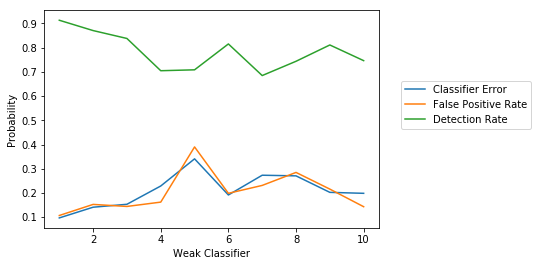

In [66]:
c = range(1,num_classifiers+1)
plt.plot(c, ClassifierError, label='Classifier Error')
plt.plot(c, FPR, label='False Positive Rate')
plt.plot(c, DR, label='Detection Rate')
plt.xlabel('Weak Classifier')
plt.ylabel('Probability')
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2)

## Test 

In [67]:
def computeHx(img, idx, p, t):
    s = integrate(features[idx], img)
    return 1 if p*s > p*t else 0 

In [68]:
def vote(img):
    cum_pix = integral_image(img)
    H = []
    for i in range(num_classifiers):
        H.append(computeHx(cum_pix, classifiers[i], polarity[i], threshold[i]))
    decision = 1 if sum(np.multiply(alpha, H)) >= 0.5*np.sum(alpha) else -1
    
    return decision

In [96]:
correct_faces = 0
correct_non_faces = 0

FaceResult = []
for i in faces_testing:
    FaceResult.append(vote(i))
correct_faces = sum(FaceResult == np.ones(len(faces_testing)))
dr_test = round((correct_faces / len(faces_testing))*100, 2)

NonFaceResult = []
for i in non_faces_testing:
    NonFaceResult.append(vote(i))
correct_non_faces = sum(NonFaceResult == np.ones(len(non_faces_testing)))
fpr_test = round((correct_non_faces / len(non_faces_testing))*100, 2)

TestResult = np.hstack((FaceResult, NonFaceResult))
TestLabel = np.hstack((np.ones(len(faces_testing)),-np.ones(len(non_faces_testing))))
TestErr = sum(TestResult!=TestLabel) / len(TestLabel)

print("Test Error :",round(TestErr*100,2),"%")
print('\n\nTest Detection Rate:\n  True Positive : ' + str(correct_faces) + '/' + str(len(faces_testing))
      + '  (' + str(dr_test) + '%)\n  False Positive: '
      + str(correct_non_faces) + '/' + str(len(non_faces_testing)) + '   ('
      + str(fpr_test) + '%)')

Test Error : 5.0 %


Test Detection Rate:
  True Positive : 97/100  (97.0%)
  False Positive: 7/100   (7.0%)


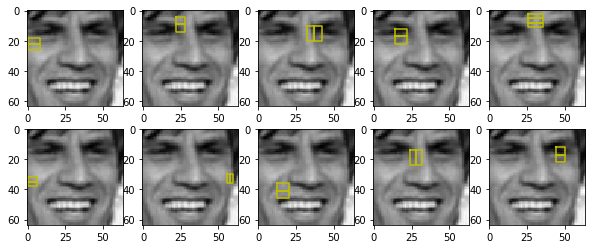

In [72]:
nrows = 2; ncols = 5
plt.figure(figsize = (ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows,ncols, i+1)
    test_face = Image.open("/Users/apple/Dev/Dataset/faces/face10.jpg").convert('L')
    plt.imshow(np.asarray(test_face), cmap = 'gray')
    
    if classifiers[i]<cnt2:
        a, b, c, d= features[classifiers[i]]
        plt.plot([a[1],b[1],b[1],a[1],a[1]],[a[0],a[0],b[0],b[0],a[0]],c="y")
        plt.plot([c[1],d[1],d[1],c[1],c[1]],[c[0],c[0],d[0],d[0],c[0]],c="y")
    else:
        a, b, c, d, e, f = features[classifiers[i]]
        plt.plot([a[1],b[1],b[1],a[1],a[1]],[a[0],a[0],b[0],b[0],a[0]],c="y")
        plt.plot([c[1],d[1],d[1],c[1],c[1]],[c[0],c[0],d[0],d[0],c[0]],c="y")
        plt.plot([e[1],f[1],f[1],e[1],e[1]],[e[0],e[0],f[0],f[0],e[0]],c="y")

## Face Detection in a large picture

In [73]:
test_img = Image.open('class.jpg').convert('L')
test_np = np.asarray(test_img)
test_np = test_np/255

rectangles = []
face_loc = []

In [78]:
# Find a location of subwindow

i= 0
while i + 64 < test_np.shape[0]:
    j= 0
    while j + 64 < test_np.shape[1]:
        rectangle = test_np[i:i+64,j:j+64]
        temp = vote(rectangle)
        if temp == 1:
            face_loc.append((i,j))
        j = j + 10
    i = i + 10

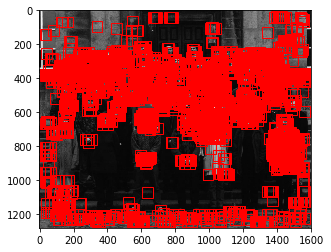

In [79]:
fig,ax = plt.subplots(1)

ax.imshow(test_np, cmap = 'gray')

for n in range(len(face_loc)):
    rect = patches.Rectangle((face_loc[n][1],face_loc[n][0]),64,64,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

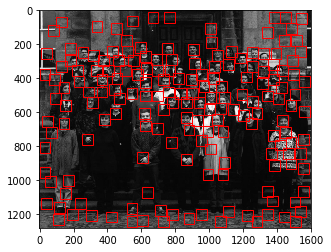

In [80]:
# exclude overlaps

faces_x = [0]
faces_y = [0]

for i in range(len(face_loc)):
    if np.all((face_loc[i][0] - np.asarray(faces_x))**2 +(face_loc[i][1] - np.asarray(faces_y))**2 > 64**2):
        faces_x.append(face_loc[i][0])
        faces_y.append(face_loc[i][1])

fig,ax = plt.subplots(1)
ax.imshow(test_np, cmap = 'gray')

for n in range(1,len(faces_x)):
    rect = patches.Rectangle((faces_y[n],faces_x[n]),64,64,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)